# Wolf-Sheep-Grass Model with Soil Creep

This notebook is meant to demonstrate coupling of an ABM implemented in Mesa and a grid-based numerical model written in Landlab.

Greg Tucker, June 2020

## Running the Mesa Wolf-Sheep-Grass model by itself

Here we just show that you can run a Mesa model in a notebook.

In [ ]:
# To install dependencies for running on mybinder.org
import sys
!{sys.executable} -m pip install mesa==0.8.7 matplotlib==3.2.1 landlab==2.1.1

In [1]:
from wolf_sheep.model import WolfSheep 
from wolf_sheep.agents import GrassPatch

In [2]:
ws = WolfSheep(grass=True)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_grass_map(model):
    grass_map = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        cell_content, x, y = cell
        for agent in cell_content:
            if type(agent) is GrassPatch:
                if agent.fully_grown:
                    grass_map[x][y] = 2
                else:
                    grass_map[x][y] = 1
    return grass_map

def plot_grass_map(grass_map):  
    plt.imshow(grass_map, interpolation='nearest')
    plt.colorbar()

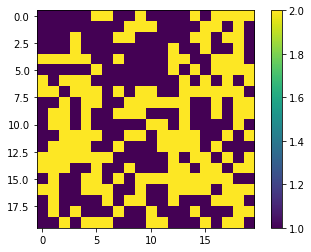

In [4]:
ws.run_model(step_count=25)
gm = generate_grass_map(ws)
plot_grass_map(gm)

## One-way coupling: using the grass cover in a soil-creep model

Here we initialize and run the W-S-G model for a short duration. We then extract its map of fully grown versus damaged grass, and use that to set the soil creep coefficient in a model of downslope soil creep. The point here is just to show that it's pretty easy to use a grid from a Mesa model as input to a Landlab-built model.

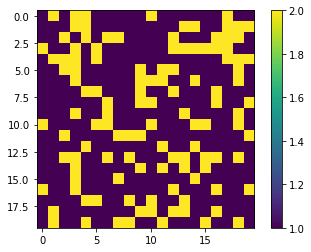

In [5]:
ws = WolfSheep(grass=True)
ws.run_model(step_count=3)
gm = generate_grass_map(ws)
plot_grass_map(gm)

In [6]:
from landlab import RasterModelGrid, imshow_grid
from landlab.components import LinearDiffuser

In [7]:
# Create a grid the same size as the W-S-G model's grid
rmg = RasterModelGrid((ws.grid.width, ws.grid.height))

# Create elevation field and have it slope down to the south at 10% gradient
elev = rmg.add_zeros('topographic__elevation', at='node')
elev[:] = 0.1 * rmg.y_of_node

# Have one open boundary on the south side
rmg.set_closed_boundaries_at_grid_edges(True, True, True, False)

# Remember the starting elevation so we can calculate cumulative erosion/deposition
initial_elev = np.zeros(rmg.number_of_nodes)
initial_elev[:] = elev

# Create a field for the creep coefficient, and set parameters for two
# rates: slow (full grass cover) and fast (partial or "eaten" grass cover)
creep_coef = rmg.add_zeros('creep_coefficient', at='node')
fast_creep = 0.1
slow_creep = 0.001

# Assign the higher creep coefficient to cells where the grass has
# been eaten and not yet recovered; the slower value is assigned to
# "fully grown" grass patches.
creep_coef[gm.flatten()==1] = fast_creep
creep_coef[gm.flatten()==2] = slow_creep

# Instantiate a LinearDiffuser (soil creep) Landlab component
diffuser = LinearDiffuser(rmg, linear_diffusivity=creep_coef)

# Set the time step duration
dt = 0.2 * rmg.dx * rmg.dx / fast_creep
print('Time step duration is ' + str(dt) + ' years.')

Time step duration is 2.0 years.


In [8]:
# Run the soil creep model
for i in range(50):
    diffuser.run_one_step(dt)

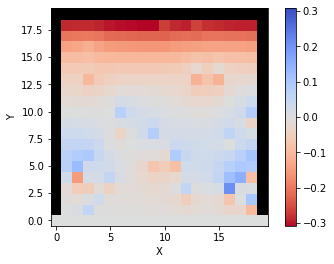

In [9]:
# Calculate and plot the erosion/deposition patterns
ero_dep = elev - initial_elev
maxchange = np.amax(np.abs(ero_dep))
imshow_grid(rmg, ero_dep, vmin=-maxchange, vmax=maxchange, cmap='coolwarm_r')

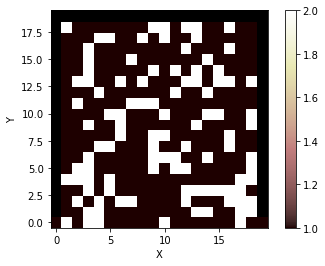

In [10]:
# Plot the grass cover again
imshow_grid(rmg, gm)

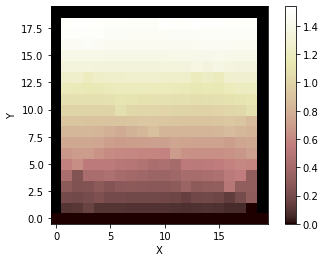

In [11]:
imshow_grid(rmg, elev)

Interestingly, erosion tends to occur at locations where grass cover upslope captures incoming soil.

## Two-way feedback

Here, we explore two-way feedback by running the two models iteratively. We track soil thickness, and "damage" any grass where the soil is thinner than a given amount. (We also limit soil flux according to its thickness, so that absent soil cannot move)

In [12]:
ws = WolfSheep(grass=True)

In [13]:
initial_soil_depth = 0.2
min_depth_for_grass = 0.2
hstar = 0.2
fast_creep = 0.1
slow_creep = 0.001

In [14]:
# Create a grid the same size as the W-S-G model's grid
rmg = RasterModelGrid((ws.grid.width, ws.grid.height))

# Create elevation field and have it slope down to the south at 10% gradient
elev = rmg.add_zeros('topographic__elevation', at='node')
elev[:] = 0.1 * rmg.y_of_node

# Have one open boundary on the south side
rmg.set_closed_boundaries_at_grid_edges(True, True, True, False)

# Remember the starting elevation so we can calculate cumulative erosion/deposition
initial_elev = np.zeros(rmg.number_of_nodes)
initial_elev[:] = elev

# Also remember the elevation of the prior time step, so we can difference
prior_elev = np.zeros(rmg.number_of_nodes)

# Create a field for the creep coefficient, and set parameters for two
# rates: slow (full grass cover) and fast (partial or "eaten" grass cover)
creep_coef = rmg.add_zeros('creep_coefficient', at='node')

# Create a soil-thickness field
soil = rmg.add_zeros('soil__depth', at='node')
soil[:] = initial_soil_depth

# Instantiate a LinearDiffuser (soil creep) Landlab component
diffuser = LinearDiffuser(rmg, linear_diffusivity=creep_coef)

# Set the time step duration
dt = 0.2 * rmg.dx * rmg.dx / fast_creep
print('Time step duration is ' + str(dt) + ' years.')

Time step duration is 2.0 years.


In [15]:
def limit_grass_by_soil(wsg_model, soil, min_soil_depth):
    soilmatrix = soil.reshape((wsg_model.width, wsg_model.height))
    for cell in wsg_model.grid.coord_iter():
        cell_content, x, y = cell
        if soilmatrix[x][y] < min_soil_depth:
            for agent in cell_content:
                if type(agent) is GrassPatch:
                    agent.fully_grown = False

In [16]:
# Main loop
for i in range(50):
    
    # Assign the higher creep coefficient to cells where the grass has
    # been eaten and not yet recovered; the slower value is assigned to
    # "fully grown" grass patches.
    gm = generate_grass_map(ws)
    creep_coef[gm.flatten()==1] = fast_creep
    creep_coef[gm.flatten()==2] = slow_creep

    # Adjust the creep coefficient to account for soil depth
    creep_coef *= 1.0 - np.exp( -soil / hstar)

    # Run the soil-creep model
    prior_elev[:] = elev
    diffuser.run_one_step(dt)
    
    # Update the soil cover
    soil += elev - prior_elev

    # Update the grass cover
    limit_grass_by_soil(ws, soil, min_depth_for_grass)
    
    # Run the W-S-G model
    ws.step()

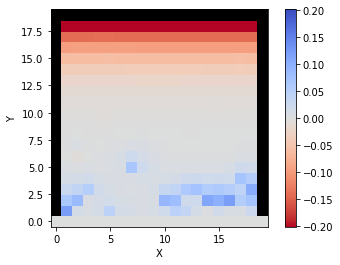

In [17]:
# Calculate and plot the erosion/deposition patterns
ero_dep = elev - initial_elev
maxchange = np.amax(np.abs(ero_dep))
imshow_grid(rmg, ero_dep, vmin=-maxchange, vmax=maxchange, cmap='coolwarm_r')

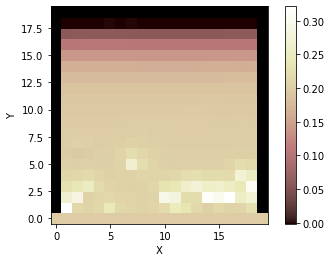

In [18]:
imshow_grid(rmg, soil)

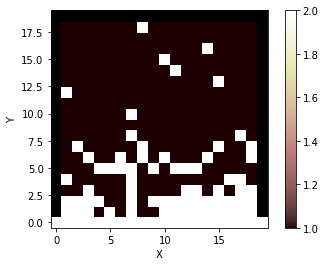

In [19]:
imshow_grid(rmg, gm)

Here soil erosion at the top of the slope inhibits grass cover, while soil accumulation at the base of the slope allows grass to continue to grow.